<a href="https://colab.research.google.com/github/jdasam/ant5015-2023/blob/main/notebooks/4th_week-auto_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autotagging

In [1]:
import torch
import torchaudio
import IPython.display as ipd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

- Download Small MTAT if you need


In [2]:
!pip install --upgrade gdown
!gdown 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
# !wget https://sogang365-my.sharepoint.com/:u:/g/personal/dasaem_jeong_o365_sogang_ac_kr/EdkHWV-qvxBEi-d0Ua73VG4BEp7EZO7HMvrXsWqeJvMJzg?e=GbYylV&download=1

!unzip -q mtat_8000.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
From (redirected): https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6&confirm=t&uuid=5e359696-4c72-455b-b2d7-abcb0985bb9f
To: /content/mtat_8000.zip
100% 921M/921M [00:08<00:00, 110MB/s] 


In [3]:
class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=6000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()
  
  def convert_label_to_tensor(self):
    return torch.tensor(self.labels.values[:, 1:-1].astype('bool'), dtype=torch.float)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    info = self.labels.iloc[idx]
    mp3_path = self.dir / info['mp3_path']

    audio, sr = torchaudio.load(mp3_path)
    assert sr == self.sr
    label = self.label_tensor[idx]
    return audio.mean(0), label

data_dir = Path('MTAT_SMALL')
dataset= MTATDataset(data_dir)
dataset[0]

(tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.8974e-08,
         -5.8156e-08, -5.6856e-08]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [4]:
dataset.labels

,clip_id,singer,harpsichord,sitar,heavy,foreign,no piano,classical,female,jazz,...,rock,dance,cello,techno,flute,beat,soft,choir,baroque,mp3_path
20552,45147,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2/zephyrus-angelus-11-ave_maria__virgo_serena_...
3899,8539,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a/tilopa-pictures_of_silence-02-ni-175-204.mp3
8996,19647,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5/arthur_yoria-of_the_lovely-04-several_mistak...
4055,8856,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/stargarden-music_for_modern_listening-02-per...
6361,13834,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,a/dac_crowell-the_mechanism_of_starlight-03-me...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,3704,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/jay_kishor-cd2_the_sowebo_concert-01-raga_ma...
4704,10328,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/tim_rayborn-veils_of_light-02-tabak-175-204.mp3
2612,5718,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1/phebe_craig_and_katherine_westine-beside_the...
21389,47024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6/john_williams-dusty_porch-11-talkin_back-88-...


In [5]:
csv_path = data_dir / "meta.csv"
df = pd.read_csv(csv_path)
len(df)
sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']

is_in_set = [True if x[0] in sub_dir_ids else False for x in df['mp3_path'].values.astype('str')]


In [6]:
torch.ones(10, dtype=torch.float) * torch.ones(10, dtype=torch.bool)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
label_tensor = torch.tensor(df.values[:, 2:-1].astype(bool), dtype=torch.long)
label_tensor[2]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [8]:
mp3_path = data_dir / df.iloc[2]['mp3_path']
y, sr = torchaudio.load(mp3_path)

In [9]:
ipd.Audio(y, rate=sr, normalize=False)

In [10]:
torchaudio.save('test.wav', y*10, sample_rate=sr)

In [11]:
y_clipped, sr = torchaudio.load('test.wav')

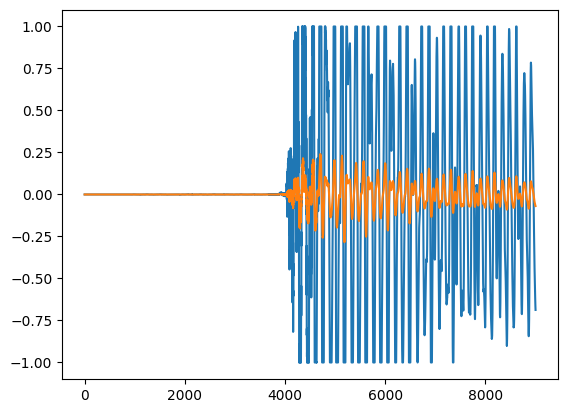

In [12]:
plt.plot(y_clipped[0, 1000:10000])
plt.plot(y[0, 1000:10000])

In [13]:
pwd

'/content'

## Make Dataset

In [14]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(data_loader))


In [15]:
audio, label = batch
audio.shape, label.shape

(torch.Size([16, 465984]), torch.Size([16, 50]))

## Make Model

In [16]:
import torch.nn as nn

class SpecConverter(nn.Module):
  def __init__(self, n_fft, hop_length, sr, n_mels):
    super().__init__()
    self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                     n_fft=n_fft, 
                                                     hop_length=hop_length, 
                                                     n_mels=n_mels)
    self.db = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db(self.spec(x)) / 100

spec_converter = SpecConverter(n_fft=1024,
                               hop_length=512,
                               sr=16000,
                               n_mels=64)

spec = spec_converter(audio)
spec.shape


torch.Size([16, 64, 911])

In [17]:
torch.max(spec), torch.min(spec)

(tensor(0.4506), tensor(-1.))

In [18]:
conv_layer = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
relu_layer = nn.ReLU()
pool_layer = nn.MaxPool1d(kernel_size=2)

out = conv_layer(spec)
out = relu_layer(out)
out = pool_layer(out)
out.shape


torch.Size([16, 128, 454])

In [19]:
# count parameters
for param in conv_layer.parameters():
  print(param.numel())

24576
128


In [20]:
# Group conv, relu, and pool
class ConvPool1d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, pool_size):
    super().__init__()
    self.conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=kernel_size)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool1d(pool_size)

  def forward(self, x):
    return self.pool(self.relu(self.conv_layer(x)))
  
conv_pool = ConvPool1d(64, 128, 3, 2)
conv_pool(spec)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0102, 0.0000, 0.0000,  ..., 0.0358, 0.0330, 0.0000],
         ...,
         [0.0910, 0.0000, 0.0000,  ..., 0.0871, 0.0851, 0.0667],
         [0.4899, 0.1714, 0.2018,  ..., 0.1620, 0.1560, 0.1908],
         [0.3561, 0.0726, 0.0593,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0501, 0.0295, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0284, 0.0000, 0.0000,  ..., 0.0306, 0.0045, 0.0037],
         ...,
         [0.1406, 0.1345, 0.0893,  ..., 0.0887, 0.0596, 0.0520],
         [0.3022, 0.1404, 0.1132,  ..., 0.1862, 0.1316, 0.1430],
         [0.3716, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0518, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0875, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [21]:
class AutoTagger(nn.Module):
  def __init__(self, hidden_size=64, output_size=50):
    super().__init__()
    self.spec = SpecConverter(n_fft=1024,
                               hop_length=512,
                               sr=16000,
                               n_mels=64)
    self.layers = nn.Sequential(ConvPool1d(64, hidden_size, 3, 2),
                                ConvPool1d(hidden_size, hidden_size*2, 3, 2),
                                ConvPool1d(hidden_size*2, hidden_size*2, 3, 2),
                                ConvPool1d(hidden_size*2, hidden_size*2, 3, 2),
                                ConvPool1d(hidden_size*2, hidden_size*2, 3, 2),
                                ConvPool1d(hidden_size*2, hidden_size*4, 3, 2),
                                ConvPool1d(hidden_size*4, hidden_size*4, 3, 2),
                                )
    self.proj = nn.Linear(hidden_size * 4, output_size)
  def forward(self, x):
    spec = self.spec(x) # N x 64 x 911
    cnn_out = self.layers(spec) # N x 256 x 5
    max_pool, _ = torch.max(cnn_out, dim=2) # N x 256

    return self.proj(max_pool).sigmoid()



    return cnn_out

model = AutoTagger()
out = model(audio)
out.shape

torch.Size([16, 50])

In [22]:
max_pool, _ = torch.max(out, dim=2)
max_pool, max_pool.shape

IndexError: ignored

## Train!

In [23]:
loss_fn = nn.BCELoss()

loss = loss_fn(out, label)


In [ ]:
from tqdm.auto import tqdm

model = AutoTagger()
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

optimizer = torch.optim.Adam(model.parameters())
n_epoch = 10
device = 'cuda'
model.to(device)
loss_record = [] 

for epoch in tqdm(range(n_epoch)):
  for batch in tqdm(data_loader, leave=False):
    audio, label = batch
    out = model(audio.to(device))
    loss = loss_fn(out, label.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())
    print(loss.item())


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.692159116268158
0.6870899200439453
0.6811884641647339
0.6735938787460327
0.6561039686203003
0.6191032528877258
0.5748141407966614
0.4260888993740082
0.3170340061187744
0.30757564306259155
0.3534988462924957
0.4270852506160736
0.30027517676353455
0.2704848349094391
0.2309022843837738
0.24924330413341522
0.2788666784763336
0.26642102003097534
0.2610473334789276
0.25164276361465454
0.2487589567899704
0.24440911412239075
0.2449468970298767
0.18281665444374084
0.2836025059223175
0.2910377085208893
0.21961013972759247
0.21885770559310913
0.18708766996860504
0.2442874163389206
0.2659549415111542
0.22615446150302887
0.24246270954608917
0.22613520920276642
0.26629868149757385
0.23251546919345856
0.2658771872520447
0.23348522186279297
0.26404401659965515
0.25361010432243347
0.21109110116958618
0.2406863421201706
0.22418838739395142
0.2621738612651825
0.2575473189353943
0.21304957568645477
0.19170993566513062
0.210393026471138
0.24407798051834106
0.268155574798584
0.2133091539144516
0.185267865

## Data Normalization

## How CNN works

In [ ]:
dummy = torch.randint(-3, 4, (2, 6,7)).float()
dummy = dummy.unsqueeze(0)
dummy, dummy.shape

In [ ]:
import torch.nn as nn
conv_layer = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, bias=False)
conv_layer.weight

In [ ]:
conv_layer.weight.shape # out_channels, in_channels, height, width
conv_layer.weight.data = torch.randint(-1, 2, (1,2,3,3)).float()
conv_layer.weight

In [ ]:
'''
2D Conv Layer의 입력은 3차원

'''
dummy, conv_layer.weight, conv_layer(dummy)

In [ ]:
conv_layer(dummy[:, 0:3, 1:4])

In [ ]:
num_ch = 4
dummy = torch.randint(-3, 4, (num_ch, 10)).float()
dummy

In [ ]:
out_ch = 6
conv1d = nn.Conv1d(num_ch, out_ch, kernel_size=3, bias=False)
conv1d.weight.data = torch.randint(-1, 2, conv1d.weight.shape).float()
conv1d.weight

In [ ]:
out = conv1d(dummy)
out, out.shape

In [ ]:
max_pool_layer = nn.MaxPool1d(3)

In [ ]:
after_pool = max_pool_layer(out)
after_pool, after_pool.shape

## Batch Norm

In [ ]:
audio

In [ ]:
model.train()
model.eval()